In [1]:
import numpy as np
import pandas as pd
import os, sys
# calculate features of small molecules
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, rdFreeSASA
from rdkit.Chem import MolSurf, Descriptors
lg = rdkit.RDLogger.logger() 
lg.setLevel(rdkit.RDLogger.CRITICAL)
from utils import get_mol
from scipy.stats import pearsonr, spearmanr
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = 'Arial'

### Classification: nonpolar-drugs or hydrophilic-drugs or charged-drugs
#### feature calculations

In [2]:
# nonpolar-drugs
with open('./data/IDR/NewCluster/nonpolar_state_mols.txt', 'r') as file:
    nonpolar_drugs = file.read().strip().split('\n')
## admetlab3.0
nonpolar_admetlab_df = pd.read_csv('./output/ADMETlab3.0/NewIDRCluster/nonpolar_state_mols.csv')
# print(len(nonpolar_drugs), len(nonpolar_admetlab_df))

# hydrophilic-drugs
with open('./data/IDR/NewCluster/hyd_state_mols.txt', 'r') as file:
    hydrophilic_drugs = file.read().strip().split('\n')
## admetlab3.0
hydrophilic_admetlab_df = pd.read_csv('./output/ADMETlab3.0/NewIDRCluster/hyd_state_mols.csv')

# charged-drugs
with open('./data/IDR/NewCluster/pos_neg_state_mols.txt', 'r') as file:
    pos_neg_drugs = file.read().strip().split('\n')
with open('./data/IDR/NewCluster/other_charge_mols.txt', 'r') as file:
    other_drugs = file.read().strip().split('\n')
charged_drugs = pos_neg_drugs + other_drugs
## admetlab3.0
pos_neg_admetlab_df = pd.read_csv('./output/ADMETlab3.0/NewIDRCluster/pos_neg_state_mols.csv')
other_admetlab_df = pd.read_csv('./output/ADMETlab3.0/NewIDRCluster/other_state_mols.csv')
charged_admetlab_df = pd.concat([pos_neg_admetlab_df, other_admetlab_df], axis=0)

In [3]:
# 溶剂可及表面积FreeSASA
def get_freesasa(smi):
    mol = get_mol(smi)
    # add H
    mol = Chem.AddHs(mol, addCoords=True)
    # 2d to 3D
    AllChem.EmbedMolecule(mol)
    # get Van der waals radii (angstrom)
    ptable = Chem.GetPeriodicTable()
    radii = [ptable.GetRvdw(atom.GetAtomicNum()) for atom in mol.GetAtoms()]
    # compute solvent accessible surface area
    sasa = rdFreeSASA.CalcSASA(mol, radii)
    return sasa


def classifyAtoms(mol, polar_atoms=[7,8,15,16]):
    #Taken from https://github.com/mittinatten/freesasa/blob/master/src/classifier.c
    symbol_radius = {"H": 1.10, "C": 1.70, "N": 1.55, "O": 1.52, "P": 1.80, "S": 1.80, "SE": 1.90,
    "F": 1.47, "CL": 1.75, "BR": 1.83, "I": 1.98,
    "LI": 1.81, "BE": 1.53, "B": 1.92,
    "NA": 2.27, "MG": 1.74, "AL": 1.84, "SI": 2.10,
    "K": 2.75, "CA": 2.31, "GA": 1.87, "GE": 2.11, "AS": 1.85,
    "RB": 3.03, "SR": 2.49, "IN": 1.93, "SN": 2.17, "SB": 2.06, "TE": 2.06}

    radii = [] 
    for atom in mol.GetAtoms():
        atom.SetProp("SASAClassName", "Apolar") # mark everything as apolar to start
        if atom.GetAtomicNum() in polar_atoms: #identify polar atoms and change their marking
            atom.SetProp("SASAClassName", "Polar") # mark as polar
        elif atom.GetAtomicNum() == 1:
            if atom.GetBonds()[0].GetOtherAtom(atom).GetAtomicNum() in polar_atoms:
                atom.SetProp("SASAClassName", "Polar") # mark as polar
        radii.append(symbol_radius[atom.GetSymbol().upper()])
    return mol, radii


def get_polar_apolar_area(smi):
    mol = get_mol(smi)
    # add H
    mol = Chem.AddHs(mol, addCoords=True)
    # 2D to 3D
    AllChem.EmbedMolecule(mol)
    # compute radii
    mol, radii = classifyAtoms(mol)
    # # get Van der waals radii (angstrom)
    # ptable = Chem.GetPeriodicTable()
    # radii = [ptable.GetRvdw(atom.GetAtomicNum()) for atom in mol.GetAtoms()]
    # compute sasa
    opts = rdFreeSASA.SASAOpts()
    sasa = rdFreeSASA.CalcSASA(mol, radii, opts=opts)
    apolar = rdFreeSASA.CalcSASA(mol, radii, query=rdFreeSASA.MakeFreeSasaAPolarAtomQuery(), opts=opts)
    polar = rdFreeSASA.CalcSASA(mol, radii, query=rdFreeSASA.MakeFreeSasaPolarAtomQuery(), opts=opts)
    return sasa, polar, apolar

In [4]:
data_df = pd.DataFrame({'smiles': nonpolar_drugs + hydrophilic_drugs + charged_drugs})
data_df['label'] = [0] * len(nonpolar_drugs) + [1] * len(hydrophilic_drugs) + [2] * len(charged_drugs)

data_df['logp1'] = [Descriptors.MolLogP(get_mol(smi)) for smi in data_df.smiles.tolist()]
data_df['logp2'] = nonpolar_admetlab_df.logP.tolist() + hydrophilic_admetlab_df.logP.tolist() + charged_admetlab_df.logP.tolist()
data_df['logD7.4'] = nonpolar_admetlab_df.logD.tolist() + hydrophilic_admetlab_df.logD.tolist() + charged_admetlab_df.logD.tolist()
data_df['logS'] = nonpolar_admetlab_df.logS.tolist() + hydrophilic_admetlab_df.logS.tolist() + charged_admetlab_df.logS.tolist()

sasas, sasa_polars, sasa_apolars =[], [], []
for smi in data_df.smiles.tolist():
    try:
        sasa, sasa_polar, sasa_apolar = get_polar_apolar_area(smi)
        sasas.append(sasa)
        sasa_polars.append(sasa_polar)
        sasa_apolars.append(sasa_apolar)
    except:
        sasas.append(None)
        sasa_polars.append(None)
        sasa_apolars.append(None)
data_df['sasa'] = sasas
data_df['sasa_polar'] = sasa_polars
data_df['sasa_apolar'] = sasa_apolars

data_df['nHD'] = [Descriptors.NumHDonors(get_mol(smi)) for smi in data_df.smiles.tolist()]
data_df['nHA'] = [Descriptors.NumHAcceptors(get_mol(smi)) for smi in data_df.smiles.tolist()]
data_df['nHE'] = [Descriptors.NumHeteroatoms(get_mol(smi)) for smi in data_df.smiles.tolist()]

data_df['nAroRings'] = [Descriptors.NumAromaticRings(get_mol(smi)) for smi in data_df.smiles.tolist()]
from utils import Calc_AP
data_df['ap'] = [Calc_AP(get_mol(smi)) for smi in data_df.smiles.tolist()]

data_df['TPSA'] = nonpolar_admetlab_df.TPSA.tolist() + hydrophilic_admetlab_df.TPSA.tolist() + charged_admetlab_df.TPSA.tolist()
data_df['nRot'] = nonpolar_admetlab_df.nRot.tolist() + hydrophilic_admetlab_df.nRot.tolist() + charged_admetlab_df.nRot.tolist()
data_df['Dense'] = nonpolar_admetlab_df.Dense.tolist() + hydrophilic_admetlab_df.Dense.tolist() + charged_admetlab_df.Dense.tolist()
data_df['fChar'] = nonpolar_admetlab_df.fChar.tolist() + hydrophilic_admetlab_df.fChar.tolist() + charged_admetlab_df.fChar.tolist()
data_df['nStereo'] = nonpolar_admetlab_df.nStereo.tolist() + hydrophilic_admetlab_df.nStereo.tolist() + charged_admetlab_df.nStereo.tolist()
data_df['Fsp3'] = nonpolar_admetlab_df.Fsp3.tolist() + hydrophilic_admetlab_df.Fsp3.tolist() + charged_admetlab_df.Fsp3.tolist()
data_df['pka_acidic'] = nonpolar_admetlab_df.pka_acidic.tolist() + hydrophilic_admetlab_df.pka_acidic.tolist() + charged_admetlab_df.pka_acidic.tolist()
data_df['pka_basic'] = nonpolar_admetlab_df.pka_basic.tolist() + hydrophilic_admetlab_df.pka_basic.tolist() + charged_admetlab_df.pka_basic.tolist()

In [5]:
data_df = data_df.dropna().reset_index(drop=True)
data_df.shape, data_df.label.value_counts()

((190, 22),
 0    109
 1     52
 2     29
 Name: label, dtype: int64)

In [6]:
data_df.head(1)

,smiles,label,logp1,logp2,logD7.4,logS,sasa,sasa_polar,sasa_apolar,nHD,...,nAroRings,ap,TPSA,nRot,Dense,fChar,nStereo,Fsp3,pka_acidic,pka_basic
0,O=C(Cc1ccc(-c2ccc(OCCN3CCOCC3)cc2)cn1)NCc1ccccc1,0,3.3185,3.210782,3.209169,-3.643156,751.474513,92.625178,658.849335,1,...,3,0.5625,63.69,10,0.943542,0,0,0.308,8.805945,7.396083


In [7]:
# data_df.to_csv('./output/ML/Drugs_diff_IDRcluster_features.csv', index=False)

### Stratified scaffold splitting
+ Done in Ubuntu platform

In [1]:
import numpy as np
import pandas as pd
import deepchem as dc
from deepchem.data import DiskDataset
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'dgl'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (/home/oyj/.conda/envs/my-torch/lib/python3.8/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'


In [2]:
# load data
data_df = pd.read_csv('./output/ML/Drugs_diff_IDRcluster_features.csv')
data_df.head(1)

,smiles,label,logp1,logp2,logD7.4,logS,sasa,sasa_polar,sasa_apolar,nHD,...,nAroRings,ap,TPSA,nRot,Dense,fChar,nStereo,Fsp3,pka_acidic,pka_basic
0,O=C(Cc1ccc(-c2ccc(OCCN3CCOCC3)cc2)cn1)NCc1ccccc1,0,3.3185,3.210782,3.209169,-3.643156,751.474513,92.625178,658.849335,1,...,3,0.5625,63.69,10,0.943542,0,0,0.308,8.805945,7.396083


In [3]:
for i, seed in enumerate([7,17,27,37,47,57,67,77,87,97]):
    # shuffle data_df
    data_df_copy = data_df.copy()
    data_df_copy = data_df_copy.sample(frac=1., random_state=seed)
    # nonpolar
    nonpolar_df = data_df_copy[data_df_copy.label == 0]
    nonpolar_dataset = DiskDataset.from_numpy(X=np.zeros(len(nonpolar_df)), ids=nonpolar_df.smiles.tolist())

    scaffold_splitter = dc.splits.ScaffoldSplitter()
    nonpolar_train, nonpolar_test = scaffold_splitter.train_test_split(nonpolar_dataset, seed=seed)

    # hydrophilic
    hydrophilic_df = data_df_copy[data_df_copy.label == 1]
    hydrophilic_dataset = DiskDataset.from_numpy(X=np.zeros(len(hydrophilic_df)), ids=hydrophilic_df.smiles.tolist())
    scaffold_splitter = dc.splits.ScaffoldSplitter()
    hydrophilic_train, hydrophilic_test = scaffold_splitter.train_test_split(hydrophilic_dataset, seed=seed)

    # charged
    charged_df = data_df_copy[data_df_copy.label == 2]
    charged_dataset = DiskDataset.from_numpy(X=np.zeros(len(charged_df)), ids=charged_df.smiles.tolist())
    scaffold_splitter = dc.splits.ScaffoldSplitter()
    charged_train, charged_test = scaffold_splitter.train_test_split(charged_dataset, seed=seed)

    train_mols = nonpolar_train.ids.tolist() + hydrophilic_train.ids.tolist() + charged_train.ids.tolist()
    splits = []
    for smi in data_df.smiles.tolist():
        if smi in train_mols:
            splits.append('train')
        else:
            splits.append('test')
    data_df[f'split_{i}'] = splits

In [4]:
data_df[data_df['split_0'] == 'train']['label'].value_counts(), data_df[data_df['split_0'] == 'test']['label'].value_counts()

(label
 0    87
 1    41
 2    23
 Name: count, dtype: int64,
 label
 0    22
 1    11
 2     6
 Name: count, dtype: int64)

In [5]:
features = data_df.columns.tolist()[-30:-10]

rf_results = {}
impr_feats = []
data_for_shap = {}

import shap

from collections import Counter

for fold in range(10):
    print(fold,':')
    train_data_df = data_df[data_df[f'split_{fold}'] == 'train']
    train_X = train_data_df.iloc[:, -30:-10].values
    train_y = train_data_df.iloc[:, 1].values
    test_data_df = data_df[data_df[f'split_{fold}'] == 'test']
    test_X = test_data_df.iloc[:, -30:-10].values
    test_y = test_data_df.iloc[:, 1].values

    rf = RandomForestClassifier(random_state=42, class_weight=None, n_estimators=100)
    rf.fit(train_X, train_y)
    # predict
    test_preds = rf.predict(test_X)
    # print(test_y, test_preds)
    acc = balanced_accuracy_score(test_y, test_preds)
    pre = precision_score(test_y, test_preds, average='weighted')
    rec = recall_score(test_y, test_preds, average='weighted')
    print(acc, pre, rec)
    rf_results[fold] = (acc, pre, rec)
    # model_dict[i] = deepcopy(rf)
    # model interpretation using SHAP value
    explainer = shap.TreeExplainer(rf, feature_names=features)
    shap_values = explainer(test_X)
    data_for_shap[fold] = shap_values

    # feature importances
    impr_feat = rf.feature_importances_.argsort()
    impr_feats.append(impr_feat[-5:])
    
rf_accs = [acc for acc, _, _ in rf_results.values()]
rf_pres = [pre for _, pre, _ in rf_results.values()]
rf_recs = [rec for _, _, rec in rf_results.values()]

print(f'Balanced accuracy: {np.mean(rf_accs):.4f} ± {np.std(rf_accs):.4f}')
print(f'Precision: {np.mean(rf_pres):.4f} ± {np.std(rf_pres):.4f}')
print(f'Recall: {np.mean(rf_recs):.4f} ± {np.std(rf_recs):.4f}')

print('Importance features:')
import_feat1 = [features[impr_feat[-1]] for impr_feat in impr_feats]
import_feat2 = [features[impr_feat[-2]] for impr_feat in impr_feats]
import_feat3 = [features[impr_feat[-3]] for impr_feat in impr_feats]
import_feat4 = [features[impr_feat[-4]] for impr_feat in impr_feats]
import_feat5 = [features[impr_feat[-5]] for impr_feat in impr_feats]

print(Counter(import_feat1))
print(Counter(import_feat2))
print(Counter(import_feat3))
print(Counter(import_feat4))
print(Counter(import_feat5))

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


0 :
0.6969696969696969 0.8069033530571992 0.7948717948717948
1 :
0.7222222222222222 0.7986813186813186 0.7692307692307693
2 :
0.6818181818181818 0.7922127255460588 0.7692307692307693
3 :
0.5808080808080808 0.6875593542260209 0.6923076923076923
4 :
0.6262626262626262 0.836228287841191 0.7692307692307693
5 :
0.7525252525252525 0.8254930966469428 0.8205128205128205
6 :
0.7626262626262627 0.7844202898550725 0.7692307692307693
7 :
0.6818181818181818 0.8235442718201339 0.7948717948717948
8 :
0.6919191919191919 0.7583882783882784 0.7435897435897436
9 :
0.6363636363636364 0.7160749506903352 0.717948717948718
Balanced accuracy: 0.6833 ± 0.0537
Precision: 0.7830 ± 0.0462
Recall: 0.7641 ± 0.0359
Importance features:
Counter({'nStereo': 4, 'logD7.4': 3, 'logp2': 3})
Counter({'logp2': 4, 'nStereo': 4, 'logD7.4': 2})
Counter({'logD7.4': 4, 'logp2': 3, 'nStereo': 2, 'TPSA': 1})
Counter({'TPSA': 3, 'ap': 2, 'sasa_polar': 2, 'logD7.4': 1, 'logp1': 1, 'nAroRings': 1})
Counter({'ap': 5, 'logp1': 2, 'TPSA

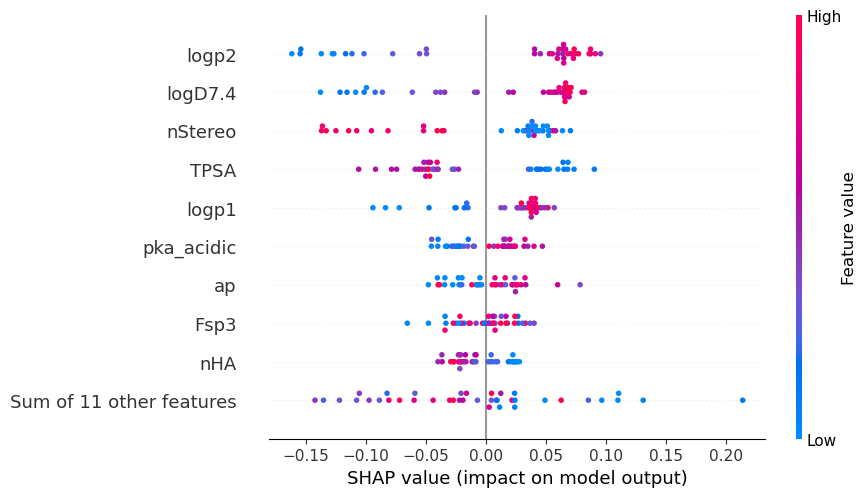

In [7]:
shap.initjs()
shap.plots.beeswarm(data_for_shap[0][:, :, 0])  # nonpolar prediction

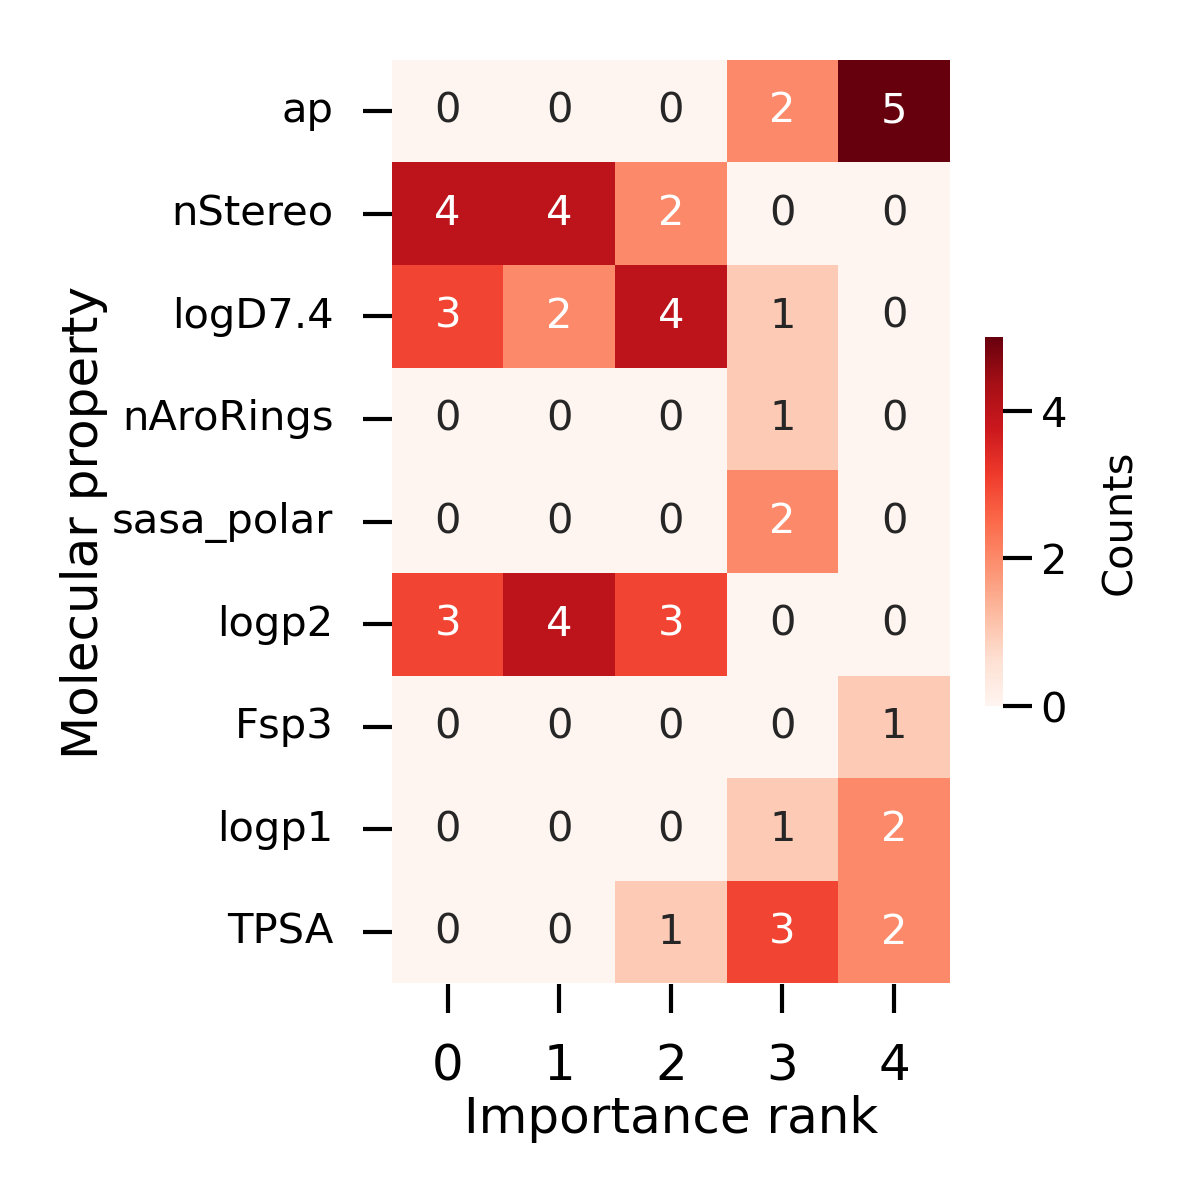

In [11]:
import_feat_unique = set(import_feat1 + import_feat2 + import_feat3 + import_feat4 + import_feat5)
import_feat_df = pd.DataFrame({
    0: [0.] * len(import_feat_unique),
    1: [0.] * len(import_feat_unique),
    2: [0.] * len(import_feat_unique),
    3: [0.] * len(import_feat_unique),
    4: [0.] * len(import_feat_unique),
}, index=list(import_feat_unique))
for feat in import_feat_unique:
    import_feat_df.loc[feat, 0] = import_feat1.count(feat)
    import_feat_df.loc[feat, 1] = import_feat2.count(feat)
    import_feat_df.loc[feat, 2] = import_feat3.count(feat)
    import_feat_df.loc[feat, 3] = import_feat4.count(feat)
    import_feat_df.loc[feat, 4] = import_feat5.count(feat)

import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(1.5,2.), dpi=600)
sns.heatmap(data=import_feat_df, ax=ax, cmap='Reds', annot=True, annot_kws={'fontsize': 5}, 
            cbar=True, cbar_kws={'shrink': 0.4})
ax.tick_params(width=0.5)
ax.set_xticklabels(import_feat_df.columns.tolist(), rotation=0, fontsize=6)
ax.set_yticklabels(import_feat_df.index.tolist(), fontsize=5)
ax.set_xlabel('Importance rank', fontsize=6, labelpad=0.5)
ax.set_ylabel('Molecular property', fontsize=6, labelpad=0.5)
# set cbar
cbar = ax.collections[0].colorbar
cbar.set_label('Counts', fontsize=5)
cbar.ax.tick_params(labelsize=5, width=0.5, pad=1)

plt.show()

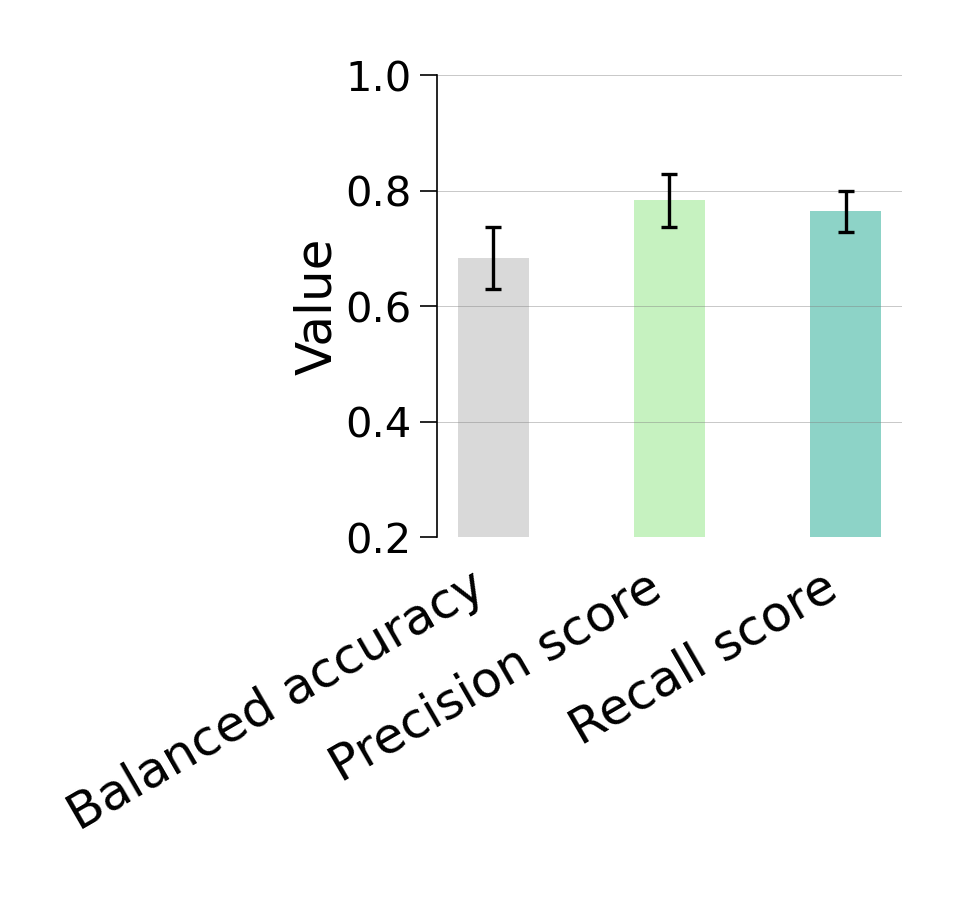

In [16]:
# balanced accuracy
fig, ax = plt.subplots(1, 1, dpi=600, figsize=(1, 1))
for h in [0.2, 0.4, 0.6, 0.8, 1.0]:
    ax.axhline(h, color="#7F7F7F", alpha=0.5, linewidth=0.1, linestyle='-')
xs = np.array([0, 1, 2])
mean_list = [np.mean(rf_accs), np.mean(rf_pres), np.mean(rf_recs)]
std_list = [np.std(rf_accs), np.std(rf_pres), np.std(rf_recs)]

err_attrs = {"elinewidth":0.4, "ecolor":"black", "capsize":1, 'capthick': 0.4}
ax.bar(xs, mean_list, width=0.4, yerr=std_list,
       error_kw=err_attrs, color=[sns.color_palette('Set3', 9)[-1], '#C6F2C0', sns.color_palette('Set3', 9)[0]])
ax.set_ylim(0.2, 1.0)
ax.spines['left'].set_linewidth(0.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(False)
ax.tick_params(labelsize=5, width=0.2, length=2, pad=1, bottom=False)
ax.set_ylabel('Value', fontsize=6, labelpad=0.5)

ax.set_xticks(xs, ['Balanced accuracy', 'Precision score', 'Recall score'], fontsize=6, rotation=30, ha='right')
# plt.savefig('./output/figures/IDRCluster_predict_metrics.png', dpi=600, bbox_inches='tight')
# plt.savefig('./output/figures/IDRCluster_predict_metrics.pdf', dpi=600, bbox_inches='tight')
plt.show()